In [1]:
import matplotlib.pyplot as plt
import numpy as np

import lsst.daf.butler as dB
import lsst.cp.verify.notebooks.utils as utils
import lsst.afw.display as afwDisplay

In [2]:
# Which calibration type to analyse.
calibType = 'flat'

# This cell should be edited to match the data to be inspected.
afwDisplay.setDefaultBackend("astrowidgets")
cameraName = 'LATISS'
physical_filter = 'empty~empty'
# physical_filter = 'RG610~empty'
genCollection = 'u/czw/DM-28920/flatGen.20210720Xb'
verifyCollection = 'u/czw/DM-28920/verifyFlat.20210720Xb'

/home/czw/.local/lib/python3.8/site-packages/ginga/cmap.py:13317: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  for name in _cm.cmap_d:


In [3]:
# Get butler and camera
butler = dB.Butler("/repo/main/", collections=[genCollection, verifyCollection])
camera = butler.get('camera', instrument=cameraName)

In [4]:
# Get Run Statistics
runStats = butler.get('verifyFlatStats', instrument=cameraName)
runSuccess = runStats.pop('SUCCESS')

In [5]:
# IW = astrowidgets.ImageWidget(image_width=1000, image_height=1000)
display = afwDisplay.Display(dims=(1000, 1000))
display.embed()

ImageWidget(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\x…

In [6]:
calib = butler.get(calibType, instrument=cameraName, detector=0, physical_filter=physical_filter)
calibArray = calib.getImage().getArray()

In [7]:
# Get simple stats
q25, q50, q75 = np.percentile(calibArray.flatten(), [25, 50, 75])
sigma = 0.74 * (q75 - q25)
print(f"Median: {q50}   Stdev: {sigma}")

display.mtv(calib)
display._scale('linear', (q50 - 3.0 * sigma), (q50 + 3.0* sigma), "")

Median: 0.9987115859985352   Stdev: 0.011343903541564941


In [8]:
blinkResiduals = True
if blinkResiduals:
    continueDisplay = True
    skipNumber = 0
    for exposureId, stats in runStats.items():
        if skipNumber > 0:
            skipNumber -= 1
            continue
            
        # TODO: support multi-detector
        detId = 0
        residual = butler.get('verifyFlatProc', instrument=cameraName, exposure=exposureId, detector=0)
        detStats = butler.get('verifyFlatDetStats', instrument=cameraName, exposure=exposureId, detector=0)

        display.mtv(residual)
        continueDisplay, skipNumber = utils.interactiveBlock(f"{exposureId} {detId}", detStats)
        if continueDisplay is False:
            break

2021011900083 0 Continue? [c, q, p, #]c
2021011900088 0 Continue? [c, q, p, #]q


In [9]:
utils.plotFailures(runStats, camera, scaleFactor=8)

ValueError: Number of columns must be a positive integer, not 0

<Figure size 0x576 with 0 Axes>

In [ ]:
config = butler.get('isr_config')
config.toDict()

In [10]:
runStats

{2021011900083: {'SUCCESS': True},
 2021011900088: {'SUCCESS': True},
 2021011900091: {'SUCCESS': True},
 2021011900092: {'SUCCESS': True},
 2021011900093: {'SUCCESS': True},
 2021011900094: {'SUCCESS': True},
 2021011900095: {'SUCCESS': True},
 2021011900096: {'SUCCESS': True},
 2021011900097: {'SUCCESS': True},
 2021011900098: {'SUCCESS': True},
 2021011900099: {'SUCCESS': True},
 2021011900100: {'SUCCESS': True},
 2021011900101: {'SUCCESS': True},
 2021011900102: {'SUCCESS': True},
 2021011900103: {'SUCCESS': True},
 2021011900104: {'SUCCESS': True},
 2021011900105: {'SUCCESS': True},
 2021011900106: {'SUCCESS': True},
 2021011900107: {'SUCCESS': True},
 2021011900108: {'SUCCESS': True},
 2021011900109: {'SUCCESS': True},
 2021011900110: {'SUCCESS': True},
 2021011900111: {'SUCCESS': True},
 2021011900112: {'SUCCESS': True},
 2021011900113: {'SUCCESS': True},
 2021011900114: {'SUCCESS': True},
 2021011900115: {'SUCCESS': True},
 2021011900116: {'SUCCESS': True},
 2021011900117: {'SU

In [11]:
# Get data for mean(darkTime) plot.
ampMeans = {}
detector = camera[0]
for amp in detector.getAmplifiers():
    ampMeans[amp.getName()] = {'ID': [], 'T': [], 'MEAN': []}

for exposureId, stats in runStats.items():
    # processed = butler.get('cpFlatProc', instrument=cameraName, exposure=exposureId, detector=0)
    residual = butler.get('verifyFlatProc', instrument=cameraName, exposure=exposureId, detector=0)
    detStats = butler.get('verifyFlatDetStats', instrument=cameraName, exposure=exposureId, detector=0)
    expTime = residual.getInfo().getVisitInfo().getExposureTime()
    
    for amp in detector.getAmplifiers():
        mean = detStats['AMP'][amp.getName()]['MEAN']
        ampMeans[amp.getName()]['ID'].append(exposureId)
        ampMeans[amp.getName()]['MEAN'].append(mean / expTime)
        ampMeans[amp.getName()]['T'].append(expTime)

<Figure size 1296x1296 with 0 Axes>

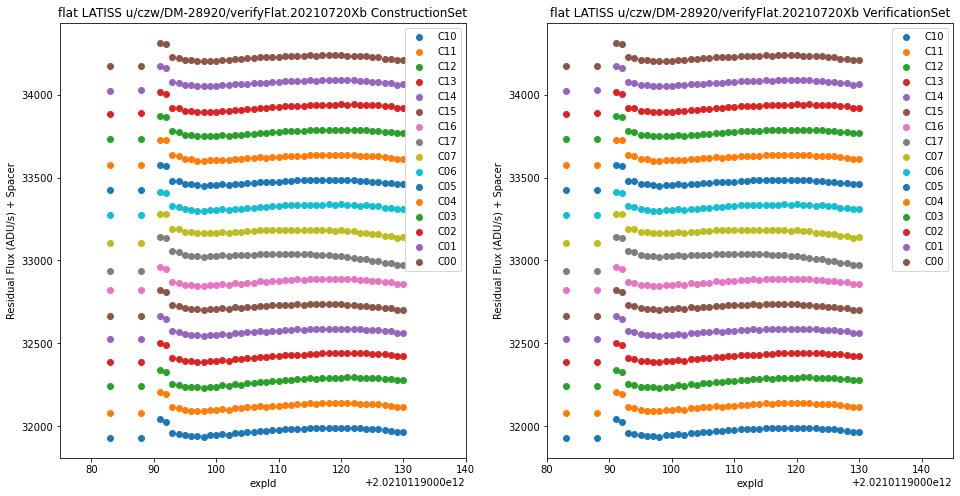

In [12]:
# plot mean as a function of exposure id, to look for time trends.
pointSpace = 0.0
elevSpace = 150
plt.figure(figsize=(18, 18))
fig, axes = plt.subplots(1, 2, figsize=(2 * 8, 8))
for axis, chunk in zip(axes, [0, 1]):
    for spacer, amp in enumerate(detector.getAmplifiers()):
        axis.scatter(np.array(ampMeans[amp.getName()]['ID']) + pointSpace * spacer,
                    np.array(ampMeans[amp.getName()]['MEAN']) + elevSpace * spacer,
                    label=amp.getName())
    axis.set_xlabel("expId")
    axis.set_ylabel("Residual Flux (ADU/s) + Spacer")

        
    if chunk == 0:
        axis.set_xlim(2021011900075, 2021011900140)
        axis.set_title(f"{calibType} {cameraName} {verifyCollection} ConstructionSet")
    else:
        axis.set_xlim(2021011900080, 2021011900145)
        axis.set_title(f"{calibType} {cameraName} {verifyCollection} VerificationSet")

    axis.legend()

<Figure size 1296x1296 with 0 Axes>

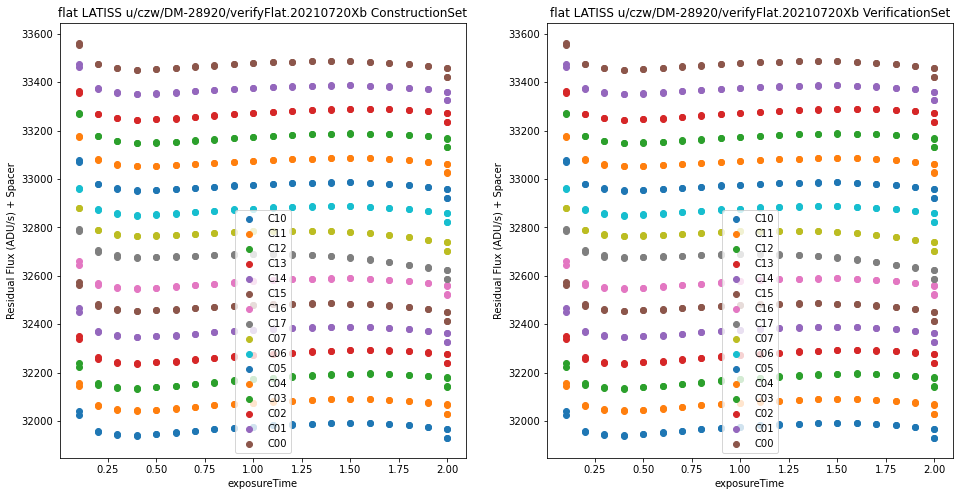

In [13]:
# plot mean as a function of exposure time, to confirm the residual is flat.
pointSpace = 0.0
elevSpace = 100
plt.figure(figsize=(18, 18))
fig, axes = plt.subplots(1, 2, figsize=(2 * 8, 8))
for axis, chunk in zip(axes, [0, 1]):
    for spacer, amp in enumerate(detector.getAmplifiers()):
        axis.scatter(np.array(ampMeans[amp.getName()]['T']) + pointSpace * spacer,
                    np.array(ampMeans[amp.getName()]['MEAN']) + elevSpace * spacer,
                    label=amp.getName())
    axis.set_xlabel("exposureTime")
    axis.set_ylabel("Residual Flux (ADU/s) + Spacer")

        
    if chunk == 0:
        # axis.set_xlim(2021011900075, 2021011900140)
        axis.set_title(f"{calibType} {cameraName} {verifyCollection} ConstructionSet")
    else:
       # axis.set_xlim(2021011900080, 2021011900145)
        axis.set_title(f"{calibType} {cameraName} {verifyCollection} VerificationSet")

    axis.legend()